# Assignment B - Networked Nations

This notebook ...

## Table of Contents

1. [Setup and Initialization](#1.-Setup-and-Initialization)
2. [Network Overview and Statistics](#2.-Network-Overview-and-Statistics)
3. [Network Topology Analysis](#3.-Network-Topology-Analysis)
4. [Node Importance and Centrality](#4.-Node-Importance-and-Centrality)
5. [Network Mixing Patterns](#5.-Network-Mixing-Patterns)
6. [Community Detection](#6.-Community-Detection)
10. [Conclusions and Summary](#10.-Conclusions-and-Summary)


## Analysis Overview

This analysis employs a comprehensive set of network science techniques:

- **Basic Statistics**: Nodes, edges, density, path lengths, clustering coefficients
- **Visualization**: ForceAtlas2 layout to reveal network structure
- **Degree Distribution**: Power-law analysis to identify scale-free properties
- **Centrality Measures**: Degree, betweenness, and eigenvector centrality
- **Topology Analysis**: Assortativity and mixing patterns
- **Community Detection**: Identify natural groupings and diplomatic blocs

## 1. Setup and Initialization

### 1.1 Import Libraries and Load Data

In [173]:
# imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms.community import louvain_communities
import json
import re
from collections import defaultdict, Counter
import random
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib
import networkx as nx
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statistics as stats
import plotly.express as px
import seaborn as sns
import matplotlib.ticker as ticker
import powerlaw
from networkx.algorithms.community import louvain_communities
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import io 
import urllib.request


# setting a random seed for reproductability
random.seed(42)

# Load the graphs
G_embassy = nx.read_gexf('/Users/smilladue/Desktop/Documents/DTU/social-graphs/IP_graph/foreign_relations_table_based_embassy_only.gexf')
G_alliance = nx.read_gexf('/Users/smilladue/Desktop/Documents/DTU/social-graphs/IP_graph/foreign_relations_table_based_with_alliance.gexf')


### 1.2 Helper Functions

This section defines utility functions for network analysis and visualization.

In [174]:
def basic_network_statistics(G, graph_name="Graph"):
    """
    Calculate basic network statistics for a graph.
    
    Parameters:
    -----------
    G : networkx.Graph
        The graph to analyze
    graph_name : str
        Name of the graph for identification
        
    Returns:
    --------
    dict : Dictionary containing all statistics
    """
    stats = {}
    stats['Graph Name'] = graph_name
    
    # Basic metrics
    stats['Number of Nodes'] = G.number_of_nodes()
    stats['Number of Edges'] = G.number_of_edges()
    
    # Degree statistics
    degrees = dict(G.degree())
    stats['Min Degree'] = min(degrees.values()) if degrees else 0
    stats['Max Degree'] = max(degrees.values()) if degrees else 0
    stats['Average Degree'] = sum(degrees.values()) / len(degrees) if degrees else 0
    
    # Density
    stats['Density'] = nx.density(G)
    
    # Connectivity metrics (only if graph is connected)
    if nx.is_connected(G):
        stats['Average Shortest Path'] = nx.average_shortest_path_length(G)
        stats['Diameter'] = nx.diameter(G)
    else:
        # For disconnected graphs, use largest component
        largest_cc = max(nx.connected_components(G), key=len)
        G_largest = G.subgraph(largest_cc)
        stats['Average Shortest Path'] = nx.average_shortest_path_length(G_largest)
        stats['Diameter'] = nx.diameter(G_largest)
        stats['Number of Components'] = nx.number_connected_components(G)
    
    # Clustering
    stats['Average Clustering Coefficient'] = nx.average_clustering(G)
    
    return stats


def compare_graphs_table(graphs_dict):
    """
    Create a comparison table for multiple graphs.
    
    Parameters:
    -----------
    graphs_dict : dict
        Dictionary with graph names as keys and networkx graphs as values
        
    Returns:
    --------
    pd.DataFrame : DataFrame with statistics for all graphs
    """
    all_stats = []
    
    for name, graph in graphs_dict.items():
        stats = basic_network_statistics(graph, name)
        all_stats.append(stats)
    
    df = pd.DataFrame(all_stats)
    df = df.set_index('Graph Name')
    
    return df

In [175]:
def plot_degree_distribution(G, graph_name="Graph", bins=50):
    """
    Plot degree distribution in both linear and log-log scale.
    """
    degrees = [d for n, d in G.degree()]
    counts, bin_edges = np.histogram(degrees, bins=bins)  
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # Filter out zero counts for log-log plot
    mask = counts > 0
    bin_centers_filtered = bin_centers[mask]
    counts_filtered = counts[mask]
    
    plt.style.use("seaborn-v0_8-whitegrid") 
    accent_color = "skyblue"
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Linear scale
    ax1.plot(bin_centers, counts, marker="o", markersize=6, linestyle="None", 
             color=accent_color, label="Degree distribution")
    ax1.set_xlabel("Degree", fontsize=12)
    ax1.set_ylabel("Number of nodes", fontsize=12)
    ax1.set_title(f"{graph_name} - Linear Scale", fontsize=13, weight="bold")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Log-log scale
    ax2.loglog(bin_centers_filtered, counts_filtered, marker="o", markersize=6,
               linestyle="None", color=accent_color, label="Degree distribution")
    ax2.set_xlabel("Degree (log scale)", fontsize=12)
    ax2.set_ylabel("Number of nodes (log scale)", fontsize=12)
    ax2.set_title(f"{graph_name} - Log-Log Scale", fontsize=13, weight="bold")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.7)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


def degree_stats(G):
    """
    Calculate key statistics for degree distribution.
    """
    degrees = [d for n, d in G.degree()]
    return {
        'mean': np.mean(degrees),
        'median': np.median(degrees),
        'min': min(degrees),
        'max': max(degrees),
        'std': np.std(degrees)
    }


def get_top_nodes(G, n=5, by='degree'):
    """Get top n nodes by specified metric."""
    if by == 'in_degree':
        ranking = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:n]
    elif by == 'out_degree':
        ranking = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:n]
    else:  # degree
        ranking = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:n]
    return ranking


def visualize_network(G, graph_name="Graph", node_attribute=None, node_size_multiplier=1.2):
    """
    Visualize network using ForceAtlas2-style layout.
    Node size based on degree, single color for now.
    For disconnected graphs we still use ForceAtlas2 but then rescale so
    the drawing fills the figure.
    """
    print(f"Visualizing {graph_name}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    # Node sizes by degree
    degrees = dict(G.degree())
    node_sizes = [degrees[n] * node_size_multiplier for n in G.nodes()]
    
    # Simple color scheme - no attribute coloring for now
    node_colors = 'purple'
    
    # Layout graph for ForceAtlas2
    if nx.is_connected(G):
        G_layout = G
        print("  Using ForceAtlas2 layout (connected graph)")
    else:
        print("  Graph is disconnected -> using ForceAtlas2 on a lightly connected copy")
        G_layout = G.copy()
        components = list(nx.connected_components(G_layout))
        reps = [next(iter(c)) for c in components]
        for i in range(len(reps) - 1):
            if not G_layout.has_edge(reps[i], reps[i+1]):
                G_layout.add_edge(reps[i], reps[i+1], weight=1e-6)
    
    pos = nx.forceatlas2_layout(
        G_layout,
        max_iter=2000,
        scaling_ratio=20.0,
        gravity=1.2,
        linlog=True,
        dissuade_hubs=False
    )

    # Rescale positions per-graph so they fill the canvas
    xs = np.array([p[0] for p in pos.values()])
    ys = np.array([p[1] for p in pos.values()])
    x_range = xs.max() - xs.min() if xs.max() != xs.min() else 1.0
    y_range = ys.max() - ys.min() if ys.max() != ys.min() else 1.0

    for node, (x, y) in list(pos.items()):
        nx_ = ((x - xs.min()) / x_range - 0.5) * 2.0   # [-1, 1]
        ny_ = ((y - ys.min()) / y_range - 0.5) * 2.0
        pos[node] = np.array([nx_, ny_])
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                           alpha=0.9, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.25, width=0.3, edge_color="#999999", ax=ax)
    
    ax.set_axis_off()
    ax.set_title(f"{graph_name}", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()


def calculate_centralities(G):
    """
    Calculate multiple centrality measures for the network.
    Returns a DataFrame with all centrality scores.
    """
    print("Calculating centralities...")
    
    centralities = pd.DataFrame(index=G.nodes())
    
    # Degree centrality
    centralities['degree'] = pd.Series(dict(G.degree()))
    centralities['degree_centrality'] = pd.Series(nx.degree_centrality(G))
    
    # Betweenness centrality
    centralities['betweenness'] = pd.Series(nx.betweenness_centrality(G, weight=None))
    
    # Eigenvector centrality (handle disconnected graphs)
    try:
        centralities['eigenvector'] = pd.Series(nx.eigenvector_centrality(G, max_iter=1000))
    except:
        print("  Warning: Eigenvector centrality failed (disconnected graph)")
        centralities['eigenvector'] = 0
    
    # Weighted versions if graph has weights
    if nx.is_weighted(G):
        centralities['betweenness_weighted'] = pd.Series(
            nx.betweenness_centrality(G, weight='weight'))
    
    return centralities

## 2. Network Overview and Statistics

### 2.1 Basic Network Statistics

In [176]:
# Display basic stats
graphs_to_compare = {
    'Diplomatic Relations: embassies': G_embassy,
    'Diplomatic Relations: alliances': G_alliance
    # 'Graph 3': G_third_graph,   # Add your third graph here
}

# Create comparison table
comparison_df = compare_graphs_table(graphs_to_compare)

# Or display as a styled DataFrame (better for Jupyter)
comparison_df.style.format({
    'Density': '{:.4f}',
    'Average Degree': '{:.2f}',
    'Average Shortest Path': '{:.4f}',
    'Average Clustering Coefficient': '{:.4f}'
})

,Number of Nodes,Number of Edges,Min Degree,Max Degree,Average Degree,Density,Average Shortest Path,Diameter,Number of Components,Average Clustering Coefficient
Graph Name,,,,,,,,,,
Diplomatic Relations: embassies,194,3826,0,172,39.44,0.2044,1.8095,3,2,0.6799
Diplomatic Relations: alliances,195,516,0,58,5.29,0.0273,2.2969,5,100,0.2176


### 2.2 Key Observations

The two networks show dramatically different characteristics:

- **Embassy Network**: Highly connected (density = 0.20), with nearly 4,000 diplomatic missions creating a dense web. The high clustering coefficient (0.68) indicates countries form tight diplomatic clusters. Very short average path length (1.81) means most countries are directly connected or separated by just one intermediary.

- **Alliance Network**: Much sparser (density = 0.03) with only 516 alliance relationships. The network is highly fragmented (100 components!) indicating many isolated alliance groups. Lower clustering (0.22) suggests alliances are less transitive than embassies.

The embassy network represents universal diplomatic infrastructure that most countries maintain, while military alliances are selective and form distinct regional/ideological blocs.

### 2.3 Network Visualization

Visual representation helps understand the overall structure and identify clusters or isolated regions.

Visualizing Diplomatic Relations: embassies: 194 nodes, 3826 edges
  Graph is disconnected -> using ForceAtlas2 on a lightly connected copy


/Users/smilladue/Desktop/Documents/DTU/social-graphs/.venv/lib/python3.13/site-packages/networkx/drawing/layout.py:1809: RuntimeWarning: invalid value encountered in divide
  attraction = -np.log(1 + distance) / distance


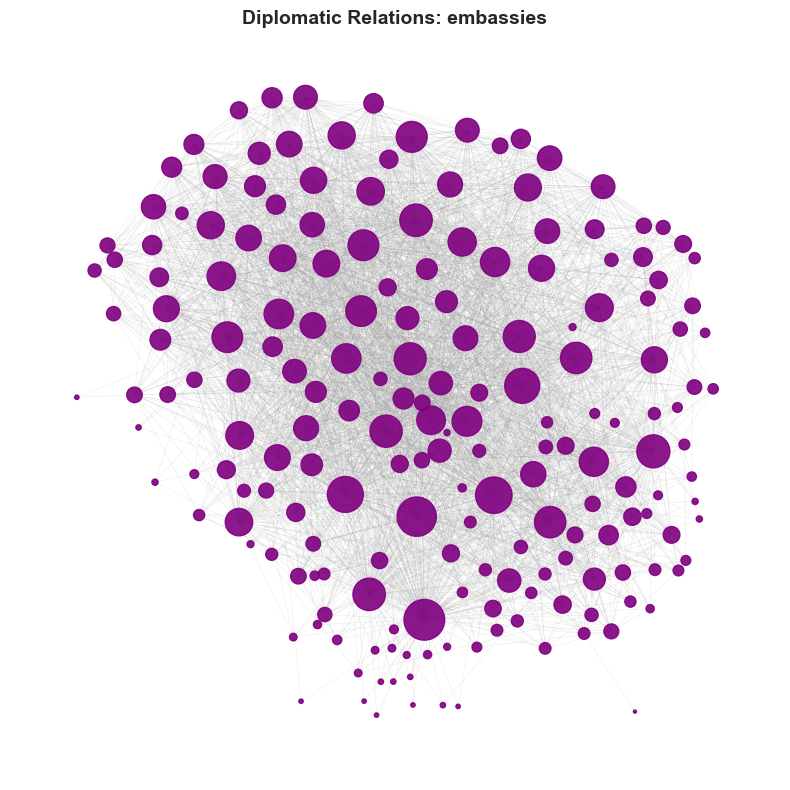

Visualizing Diplomatic Relations: alliances: 195 nodes, 516 edges
  Graph is disconnected -> using ForceAtlas2 on a lightly connected copy


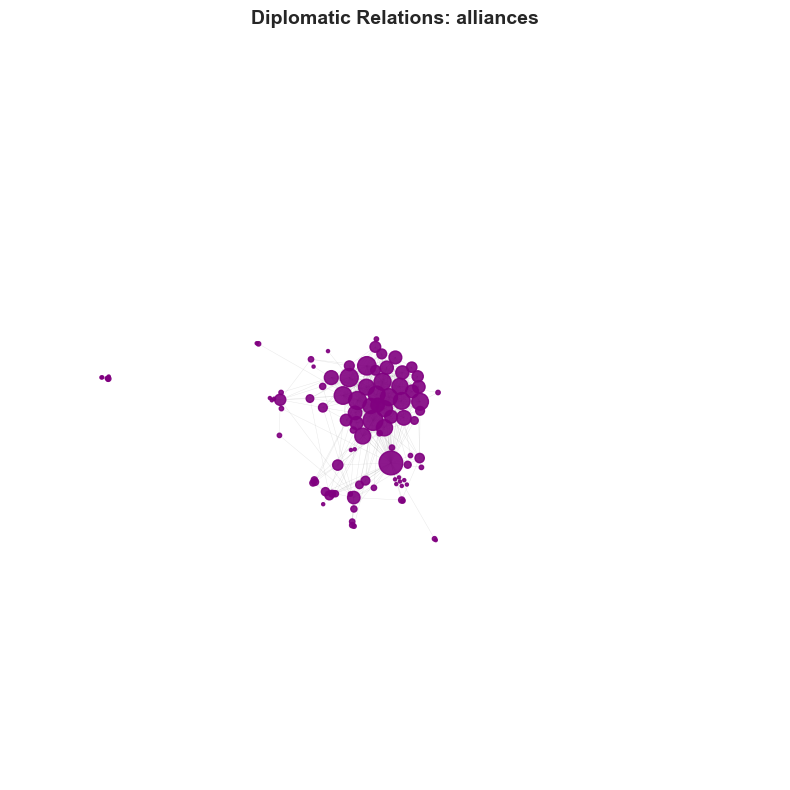

In [177]:
# Visualize each network
# Note: Adjust node_size_multiplier based on your network size
for name, graph in graphs_to_compare.items():
    visualize_network(graph, graph_name=name, node_size_multiplier=5)

### 2.4 Visual Insights

The ForceAtlas2 layout clearly reveals the structural differences:

- **Embassy Network**: Forms a dense, interconnected core with few isolated nodes. The hub-and-spoke pattern is visible with major powers (large nodes) connecting broadly across the network.

- **Alliance Network**: Shows clear fragmentation with multiple disconnected clusters. The largest component appears to be NATO-centric (European/North American bloc), with other smaller alliance groups scattered separately. This visualization confirms the 100 components from the statistics table.

## 3. Network Topology Analysis

### 3.1 Degree Distribution

Understanding the degree distribution helps us determine if the network is scale-free (power-law) or more random-like. A linear trend in log-log space suggests a scale-free network with hubs.

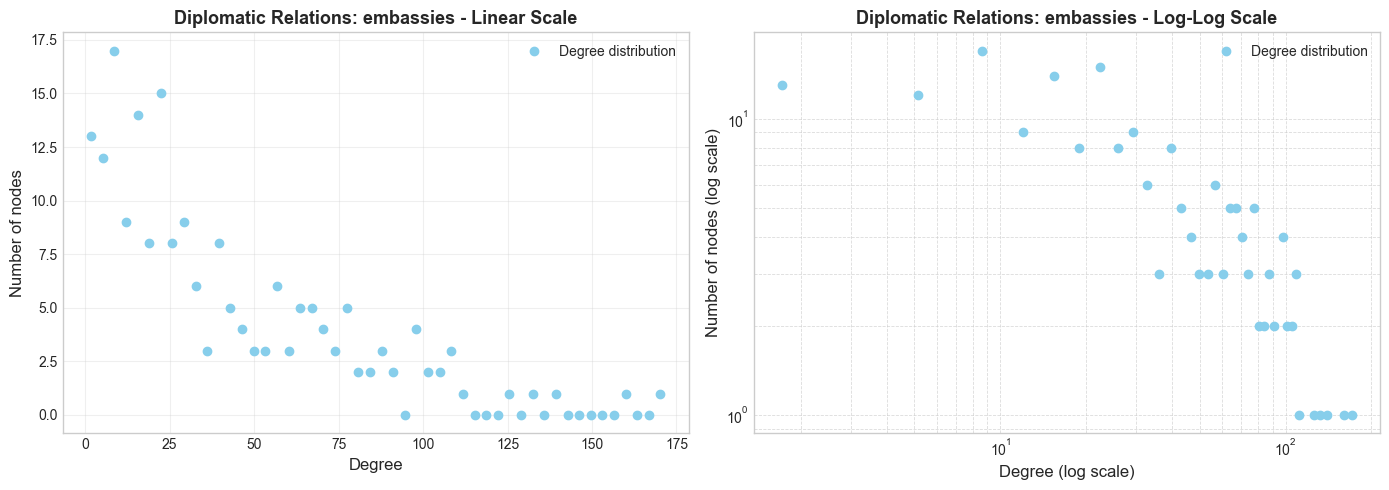

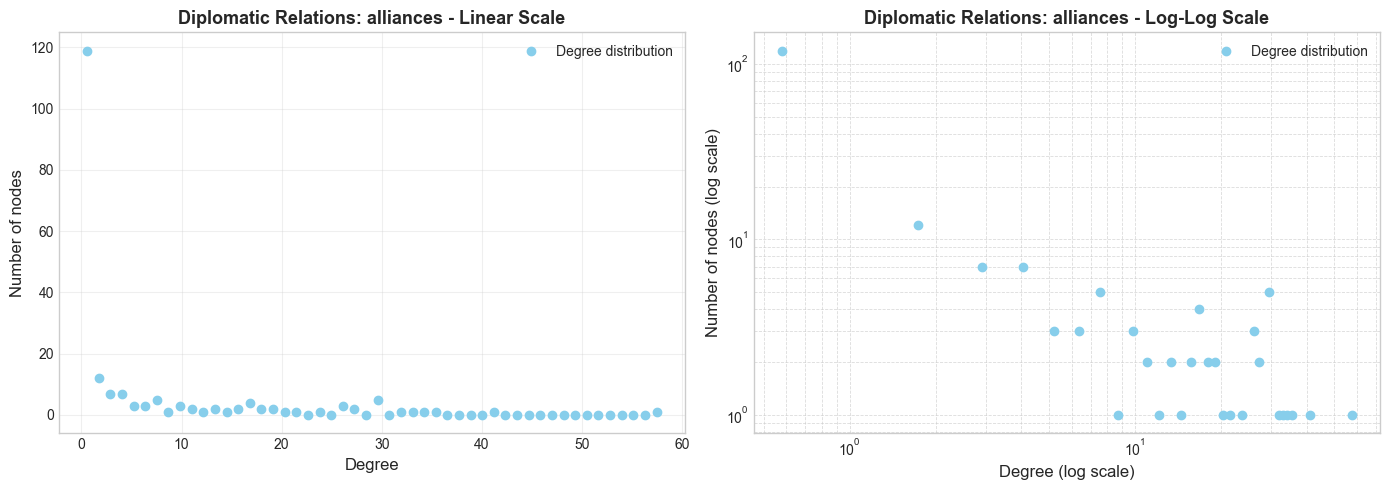

In [178]:
# Plot degree distributions for all graphs
for name, graph in graphs_to_compare.items():
    plot_degree_distribution(graph, graph_name=name)

#### Interpretation

- **Embassy Network**: The log-log plot shows a somewhat linear trend, indicating scale-free characteristics with major powers dominating. However, the distribution is not a pure power-law (as confirmed by the exponent analysis below).

- **Alliance Network**: The degree distribution is extremely right-skewed with most countries having very few alliances (median = 1). The log-log plot shows less linearity, suggesting this network is less scale-free and more exponential in nature.

### 3.2 Power-Law Exponent Analysis

Calculate the power-law exponent (γ) to quantify the degree distribution:
- **γ ∈ (2,3)**: Scale-free network with strong hubs
- **γ > 3**: More random-like, weaker hubs

In [179]:
# Calculate power-law exponent for each graph
print("Power-Law Exponent Analysis")
print("="*60)

for name, graph in graphs_to_compare.items():
    degrees = [d for n, d in graph.degree() if d > 0]
    
    # Use powerlaw package for proper fitting
    fit = powerlaw.Fit(degrees, discrete=True, verbose=False, xmin=1)
    
    gamma = fit.power_law.alpha
    
    # Compare to exponential
    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    
    print(f"\n{name}:")
    print(f"  γ = {gamma:.2f}")
    
    if R > 0 and p < 0.1:
        dist_type = "power-law"
    elif R < 0 and p < 0.1:
        dist_type = "exponential"
    else:
        dist_type = "unclear"
    
    print(f"  Distribution: {dist_type} (p={p:.3f})")
    
    if 2 < gamma < 3:
        print(f"  → Scale-free (strong hubs)")
    elif gamma > 3:
        print(f"  → Random-like (weak hubs)")

print("\n" + "="*60)

Power-Law Exponent Analysis

Diplomatic Relations: embassies:
  γ = 1.26
  Distribution: exponential (p=0.000)

Diplomatic Relations: alliances:
  γ = 1.42
  Distribution: exponential (p=0.096)



#### Analysis

Both networks have γ values in the **anomalous regime (γ < 2)**, which theoretically indicates super-hubs with extreme influence. However, both are better fit by exponential distributions rather than pure power-laws:

- **Embassy Network** (γ = 1.26): Strongly exponential fit (p < 0.001). This is a **broad-scale network** - it has hubs but with practical constraints. Major powers maintain many embassies, but diplomatic infrastructure requires resources that limit extreme preferential attachment.

- **Alliance Network** (γ = 1.42): Marginally exponential (p = 0.096). Even less scale-free than the embassy network. Military alliances are highly selective and strategic, not following preferential attachment patterns.

Both networks show heavy tails (influential hubs exist) but don't follow pure power-law dynamics. This makes sense: diplomatic relations are constrained by geography, resources, and political calculations rather than pure "rich-get-richer" dynamics.

## 4. Node Importance and Centrality

### 4.1 Top Connected Nodes

Identifying the most connected nodes (countries) reveals the key players and hubs in the diplomatic network.

In [180]:
# Find top nodes for each graph
for name, graph in graphs_to_compare.items():
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    
    # Check if directed or undirected
    if graph.is_directed():
        print(f"\nTop 5 nodes by IN-DEGREE:")
        for node, degree in get_top_nodes(graph, n=5, by='in_degree'):
            print(f"  {node}: {degree}")
        
        print(f"\nTop 5 nodes by OUT-DEGREE:")
        for node, degree in get_top_nodes(graph, n=5, by='out_degree'):
            print(f"  {node}: {degree}")
    else:
        print(f"\nTop 5 nodes by DEGREE:")
        for node, degree in get_top_nodes(graph, n=5, by='degree'):
            print(f"  {node}: {degree}")


Diplomatic Relations: embassies

Top 5 nodes by DEGREE:
  the United Kingdom: 172
  Germany: 160
  Mexico: 138
  Turkey: 134
  Spain: 127

Diplomatic Relations: alliances

Top 5 nodes by DEGREE:
  Turkey: 58
  Poland: 41
  Italy: 35
  Greece: 34
  Spain: 33


#### Key Players

- **Embassy Network**: The UK leads with 172 connections (nearly connecting to every country), followed by Germany (160) and Mexico (138). These are classic diplomatic hubs - established powers with global reach. The US ranks 5th in degree despite being a superpower, possibly due to selective diplomatic presence.

- **Alliance Network**: Turkey dominates with 58 alliance connections, likely reflecting its strategic position in NATO and Middle East. Poland, Italy, Greece, and Spain follow - all NATO members, suggesting NATO creates a dense alliance subnetwork. The alliance network leaders are more regionally focused than the embassy leaders.

### 4.2 Multiple Centrality Measures

Centrality measures reveal which countries are most important in the network through different lenses:
- **Degree**: Direct connections
- **Betweenness**: Bridge positions (control of information flow)
- **Eigenvector**: Connected to other important nodes

In [181]:
# Calculate centralities for each graph
centrality_results = {}

for name, graph in graphs_to_compare.items():
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}\n")
    
    cent_df = calculate_centralities(graph)
    centrality_results[name] = cent_df
    
    # Create summary showing top nodes for each centrality
    summary_data = []
    
    # Top 5 by betweenness
    top_bet = cent_df.nlargest(5, 'betweenness')
    for rank, (country, row) in enumerate(top_bet.iterrows(), 1):
        summary_data.append({
            'Rank': rank,
            'Betweenness Top': country,
            'Betweenness': row['betweenness']
        })
    
    # Top 5 by eigenvector (if available)
    if cent_df['eigenvector'].sum() > 0:
        top_eig = cent_df.nlargest(5, 'eigenvector')
        for rank, (country, row) in enumerate(top_eig.iterrows(), 1):
            summary_data[rank-1]['Eigenvector Top'] = country
            summary_data[rank-1]['Eigenvector'] = row['eigenvector']
    
    summary_df = pd.DataFrame(summary_data).set_index('Rank')
    
    print("Top 5 Countries by Centrality Measure:")
    display(summary_df.style.format({
        'Betweenness': '{:.4f}',
        'Eigenvector': '{:.4f}'
    }))


Diplomatic Relations: embassies

Calculating centralities...
Top 5 Countries by Centrality Measure:
Top 5 Countries by Centrality Measure:


,Betweenness Top,Betweenness,Eigenvector Top,Eigenvector
Rank,,,,
1,the United Kingdom,0.1472,Germany,0.1667
2,Germany,0.0778,the United Kingdom,0.1645
3,Mexico,0.0582,Turkey,0.1542
4,Turkey,0.0393,Spain,0.1502
5,the United States,0.0348,Mexico,0.1477



Diplomatic Relations: alliances

Calculating centralities...
Top 5 Countries by Centrality Measure:


,Betweenness Top,Betweenness,Eigenvector Top,Eigenvector
Rank,,,,
1,Turkey,0.0865,Turkey,0.2436
2,Spain,0.0195,Poland,0.2382
3,Syria,0.0187,Italy,0.2197
4,Indonesia,0.0183,Spain,0.2156
5,France,0.0153,Greece,0.2116


#### Centrality Insights

**Betweenness Centrality** (bridge positions):
- **Embassy**: UK dominates (0.147), acting as a critical bridge between different diplomatic clusters. Germany (0.078) and Mexico (0.058) also serve as important connectors. High betweenness suggests these countries facilitate communication and influence flows.
- **Alliance**: Turkey again leads (0.087) but with much lower absolute values overall, reflecting the fragmented alliance structure where few countries bridge different alliance blocs.

**Eigenvector Centrality** (connected to other important nodes):
- **Embassy**: Germany and UK are nearly tied (~0.166), indicating they're not just well-connected but connected to *other* well-connected countries - true diplomatic elite.
- **Alliance**: Turkey (0.244) leads but is closely followed by other NATO members (Poland, Italy). This suggests NATO forms a tightly interconnected "prestigious" alliance cluster where members mutually reinforce each other's importance.

Interesting: In the embassy network, betweenness and eigenvector centrality identify slightly different countries, suggesting structural diversity. In alliances, they're more aligned, indicating a more hierarchical structure.

### 4.3 Centrality Comparison Visualization

Visualize how different centrality measures relate to degree centrality.

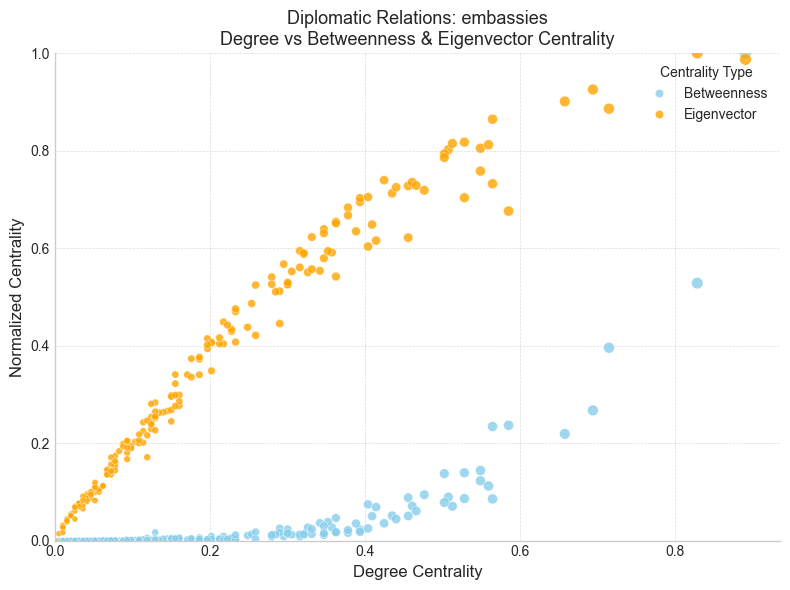

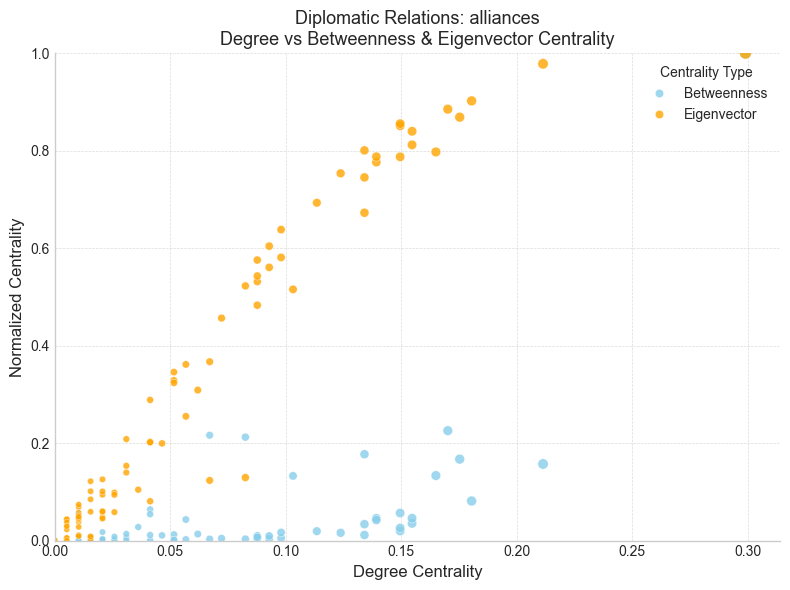

In [182]:
# Plot centrality comparisons (Assignment 2 style)
for name, cent_df in centrality_results.items():
    # Normalize centralities to 0-1 range
    cent_df['betweenness_norm'] = (
        (cent_df['betweenness'] - cent_df['betweenness'].min()) / 
        (cent_df['betweenness'].max() - cent_df['betweenness'].min())
    )
    
    if cent_df['eigenvector'].sum() > 0:
        cent_df['eigenvector_norm'] = (
            (cent_df['eigenvector'] - cent_df['eigenvector'].min()) / 
            (cent_df['eigenvector'].max() - cent_df['eigenvector'].min())
        )
        
        # Melt into long format
        plot_df = cent_df.melt(
            id_vars=['degree_centrality', 'degree'],
            value_vars=['betweenness_norm', 'eigenvector_norm'],
            var_name='centrality_type',
            value_name='normalized_value'
        )
        
        # Clean labels
        plot_df['centrality_type'] = plot_df['centrality_type'].replace({
            'betweenness_norm': 'Betweenness',
            'eigenvector_norm': 'Eigenvector'
        })
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.scatterplot(
            data=plot_df, x='degree_centrality', y='normalized_value',
            hue='centrality_type', size='degree',
            palette={'Betweenness': 'skyblue', 'Eigenvector': 'orange'},
            alpha=0.8, ax=ax, legend='brief'
        )
        
        # Legend cleanup
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:3], labels=labels[1:3], title="Centrality Type")
        
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.set_xlim(left=0)
        ax.set_ylim(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel("Degree Centrality", fontsize=12)
        ax.set_ylabel("Normalized Centrality", fontsize=12)
        ax.set_title(f"{name}\nDegree vs Betweenness & Eigenvector Centrality", fontsize=13)
        plt.tight_layout()
        plt.show()

#### Plot Interpretation

Both networks show positive correlations between degree centrality and other centrality measures, but with important differences:

- **Embassy Network**: Strong positive correlation between degree and both betweenness/eigenvector centrality. High-degree countries naturally occupy bridge positions and connect to other important countries. The scatter is relatively tight, suggesting degree is a good predictor of other centralities.

- **Alliance Network**: The correlation is present but with more scatter, especially at lower degrees. This suggests that in alliance networks, *who* you're connected to matters more than *how many* connections you have. A country with few but strategic alliances can have disproportionate influence.

Both plots show that larger nodes (higher degree) tend to have higher normalized centrality values, confirming the hub structure seen in earlier analyses.

## 5. Network Mixing Patterns

### 5.1 Assortativity Analysis

Do highly connected countries tend to connect with other highly connected countries? This reveals mixing patterns in the network.

In [183]:
# Calculate assortativity for each graph
print("Assortativity Analysis")
print("="*60)

for name, graph in graphs_to_compare.items():
    # Degree assortativity
    assort_deg = nx.degree_assortativity_coefficient(graph)
    
    print(f"\n{name}:")
    print(f"  Degree assortativity: {assort_deg:.4f}")
    
    if assort_deg > 0.1:
        print("  → Assortative: High-degree nodes connect to high-degree nodes")
    elif assort_deg < -0.1:
        print("  → Disassortative: High-degree nodes connect to low-degree nodes (hub-spoke)")
    else:
        print("  → Neutral mixing pattern")

print("\n" + "="*60)

Assortativity Analysis

Diplomatic Relations: embassies:
  Degree assortativity: -0.3551
  → Disassortative: High-degree nodes connect to low-degree nodes (hub-spoke)

Diplomatic Relations: alliances:
  Degree assortativity: -0.1447
  → Disassortative: High-degree nodes connect to low-degree nodes (hub-spoke)



#### Assortativity Findings

Both networks are **disassortative** (negative assortativity coefficients), meaning high-degree nodes preferentially connect to low-degree nodes, creating hub-and-spoke structures:

- **Embassy Network** (-0.36): Strongly disassortative. Major diplomatic powers (UK, Germany) maintain embassies in many smaller countries that may only have a few embassies total. This creates a hierarchical structure where hubs don't primarily connect to each other but rather to the periphery.

- **Alliance Network** (-0.14): Moderately disassortative. Countries with many alliances (like Turkey) connect to countries with fewer alliances. However, this is weaker than the embassy network, suggesting some degree of alliance clustering (e.g., NATO countries connecting to each other).

**Implication**: Neither network forms "rich clubs" where the most connected countries primarily link to each other. Instead, diplomatic and alliance patterns reflect practical reach where major powers extend connections to smaller nations, rather than forming exclusive elite networks. This is consistent with real-world diplomatic and security strategies where major powers seek to maximize their influence rather than just cluster with peers.

## 6. Community Detection

### 6.1 Community Structure Analysis

Identify natural groupings of countries that form tightly connected diplomatic or alliance communities.

### 6.2 Community Visualization

Visualize the network with communities color-coded to reveal regional, political, or strategic groupings.

### 6.3 Community Characteristics

Analyze the properties of each community (size, internal density, key members).

## 10. Conclusions and Summary

### 10.1 Key Findings

Summarize the main insights from the network analysis.

### 10.2 Comparative Analysis

Compare and contrast the embassy and alliance networks across all metrics.

### 10.3 Implications and Future Work

Discuss real-world implications and potential extensions of this analysis.